In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

font = {'weight': 'normal', 'family': 'DejaVu Sans'}
plt.rc('text', usetex = True)
plt.rc('font', **font)
plt.rcParams['font.size'] = 24


def format_power(x):
    
    power = int("{:.2e}".format(x).split('e')[1])
    val = float("{:.2e}".format(x).split('e')[0])
    
    return r'%.2f \cdot 10^{%d}' % (val, power)

def load_data_slices():
    
    data = np.load('gen_slices_data.npz', 
                    allow_pickle = True)

    return (data['sigvar'], data['numar'], 
            data['sigar'], data['avar'], data['mcpc'], 
            data['params'], data['dim'], data['gamma'])

def load_data_pdiag():
    
    data = np.load('gen_diag_nonmarkov_data.npz', 
                    allow_pickle = True)
    
    
    sigvPCN = data['sigvPCN'].flatten()
    sigvMCPC = data['sigvMCPC'].flatten()
    sigvMCPCbis = data['sigvMCPCbis'].flatten()
    phiar = data['phiar']
    thr = 0.02

    nansigvMCPC = np.isnan(sigvMCPC)
    nansigvMCPCbis = np.isnan(sigvMCPCbis)
    nansigvPCN = np.isnan(sigvPCN)

    sigvMCPC = sigvMCPC[~nansigvMCPC]
    sigvMCPCbis = sigvMCPCbis[~nansigvMCPCbis]
    sigvPCN = sigvPCN[~nansigvPCN]

    phiarMCPC = phiar[~nansigvMCPC]
    phiarMCPCbis = phiar[~nansigvMCPCbis]
    phiarPCN = phiar[~nansigvPCN]

    mcpc = np.concatenate((sigvMCPC, sigvMCPCbis, sigvPCN[phiarPCN <= 0.02]))
    phi_mcpc = np.concatenate((phiarMCPC, phiarMCPCbis, phiarPCN[phiarPCN <= 0.02]))

    argsrt = np.argsort(mcpc).flatten()
    mcpc = mcpc[argsrt]
    phi_mcpc = phi_mcpc[argsrt]

    pcn = sigvPCN
    phi_pcn = phiarPCN

    p = np.poly1d(np.polyfit(np.log(mcpc), np.log(phi_mcpc), 5))

    return (mcpc, np.exp(p(np.log(mcpc))), pcn, phi_pcn,
            data['nu'], data['kappa'], data['gamma'])


def save_fig(figs, figname):

    if (type(figs) is list):
        for q, fig in enumerate(figs):
            fig.savefig('%s_%d.svg' % (figname, q), bbox_inches = 'tight')
            fig.savefig('%s_%d.pdf' % (figname, q), bbox_inches = 'tight')
            fig.savefig('%s_%d.png' % (figname, q), bbox_inches = 'tight', dpi = 300)
    else:
        figs.savefig('%s.svg' % (figname), bbox_inches = 'tight')
        figs.savefig('%s.pdf' % (figname), bbox_inches = 'tight')
        figs.savefig('%s.png' % (figname), bbox_inches = 'tight', dpi = 300)


def set_size(w,h,ax):
    Bbox = ax.get_position()
        
    l = Bbox.x0
    r = Bbox.x1
    t = Bbox.y1
    b = Bbox.y0

    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)   
        

In [3]:
def simulate(sigv, l, m, sig, gamma, phi, nu, kick = 0.2, snapshots = [1, 3, 9]):
    
    prng = np.random.RandomState()
    dim = 2
    q = 2
    
    burn = 0
    
    xp = []
    alive = [[] for i in range(l + burn + 1)]
    xv = prng.normal(kick, sigv/np.sqrt(dim), size = (l + 1 + burn,dim))
    xv[0,:] = 0

    dx = np.zeros(dim)
    snapshots = np.array(snapshots) #+ burn
    snaps = []
    
    
    for j in range(l + burn):
        current = []


        if j in snapshots:
            snap = []
            for i in alive[j]:
                snap.append(np.copy(xp[i]))

            snaps.append(snap)
        
        
        for i in range(len(xp)):
            for n in range(dim):
                xp[i][n] -= dx[n]
        
        for snap in snaps:
            for i in range(len(snap)):
                for n in range(dim):
                    snap[i][n] -= dx[n]
                    
        for i in alive[j]:
   
            k = int(prng.binomial(xp[i][dim], gamma))
            xp[i][dim] = k
            
            if( k > 0):
                alive[j+1].append(i)
                
        for i in alive[j+1]:
            
            d = 0
            for n in range(dim):
                d += xp[i][n]**2
                
            d = np.sqrt(d)
            k = int(prng.binomial(xp[i][dim], nu*np.exp(-d**q)))
            xp[i][dim] += k
            

    
        sp = prng.poisson(m)
        ini_xp = len(xp)
        
        for k in range(sp):
            xp.append(np.append(prng.normal(0, sig/np.sqrt(dim), size = dim), [1, ini_xp + k]))
            alive[j+1].append(ini_xp + k)
                      
                      
        for n in range(dim):
            dx[n] = xv[j+1,n]
           
       
    z = np.cumsum(xv[:-1], axis = 0)
    z = z - z[-1, :]
    
    
    snaps_xv = []
    
    for i in snapshots:
        snaps_xv.append(z[:i,:])
        
    
    return snaps, snaps_xv


def clips(xp, xv, labels, phi, cmap = None, axs = None, offset = 6):
    
    size = 300
    Dx = (np.max(xv[-1][:,0]) + np.min(xv[-1][:,0]))/2
    Dy = (np.max(xv[-1][:,1]) + np.min(xv[-1][:,1]))/2
    eps = np.array([Dx, Dy, 0, 0])[np.newaxis, :]    
    Lbox = max(np.abs(np.max(xv[-1][:,0])- np.min(xv[-1][:,0])),
               np.abs(np.max(xv[-1][:,1])- np.min(xv[-1][:,1])))/2 + offset
    
    
    xs = np.linspace(-Lbox, Lbox, size)
    ys = np.linspace(-Lbox, Lbox, size)
    xs, ys = np.meshgrid(xs, ys)

    
    vmins = []
    vmaxs = []
    

    for j in range(len(xp)):
        
        if (len(xp[j]) > 0):
            
            xp_temp = np.array(xp[j]) - eps
            zzp = xp_temp[:,2,np.newaxis,np.newaxis]*\
                        np.exp(-np.sqrt((xs[np.newaxis,:,:] - xp_temp[:,0,np.newaxis,np.newaxis])**2 
                                      + (ys[np.newaxis,:,:] - xp_temp[:,1,np.newaxis,np.newaxis])**2))

            zp = np.minimum(phi, 1/(np.sum(zzp, axis = 0)))
        else:
            zp = phi
        
        vmins.append(np.min(np.log10(zp)))
    
    vmin = min(vmins)
    vmax = np.log10(phi)
    
    if (cmap is None):
        cmap = sns.color_palette("Purples_r", as_cmap = True)
        
    norm = mpl.colors.Normalize(vmin  = vmin, vmax = vmax)
    levels = np.linspace(vmin, vmax, 12)
    
    for j in range(len(xp)):

        if (axs == None):
            fig, ax = plt.subplots()
        else:
            ax = axs[j]
            

        if (len(xp[j]) > 0):
            xp_temp = np.array(xp[j]) - eps
            zzp = xp_temp[:,2,np.newaxis,np.newaxis]*\
                        np.exp(-np.sqrt((xs[np.newaxis,:,:] - xp_temp[:,0,np.newaxis,np.newaxis])**2 
                                      + (ys[np.newaxis,:,:] - xp_temp[:,1,np.newaxis,np.newaxis])**2))
            zp = np.minimum(100, 1/(np.sum(zzp, axis = 0)))
            inside = np.logical_and(np.abs(xp_temp[:,0]) < Lbox, np.abs(xp_temp[:,1]) < Lbox)
            ax.plot(xp_temp[inside,0], xp_temp[inside,1], 'ko',
                    markersize = 3)
            
        else:
            zp = 100*np.ones((size, size))
            
        cf2 = ax.contourf(xs, ys, np.log10(zp), levels = levels, norm = norm, cmap = cmap)

        ax.plot(xv[j][:,0] - Dx, xv[j][:,1] - Dy, 'k', 
                linestyle = '-', linewidth = 1.1, )
        ax.plot(xv[j][:,0] - Dx, xv[j][:,1] - Dy, 'ro',
               markersize = 6)
        ax.set_xlim([-Lbox, Lbox])
        ax.set_ylim([-Lbox, Lbox])
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.annotate(r'$t = %d$' % labels[j], (0.05, 0.88), xycoords = ax.transAxes)
        
        if(j == 0):
            ax.set_xlabel('Antigenic coordinate')
            ax.set_ylabel('Antigenic coordinate')
            
    return cf2, norm

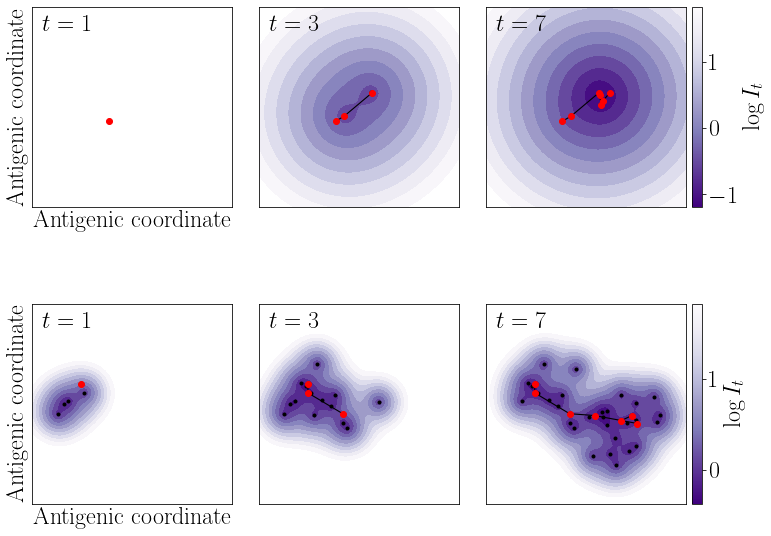

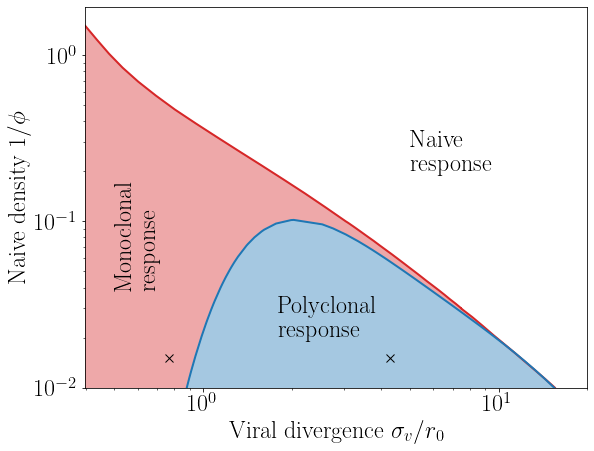

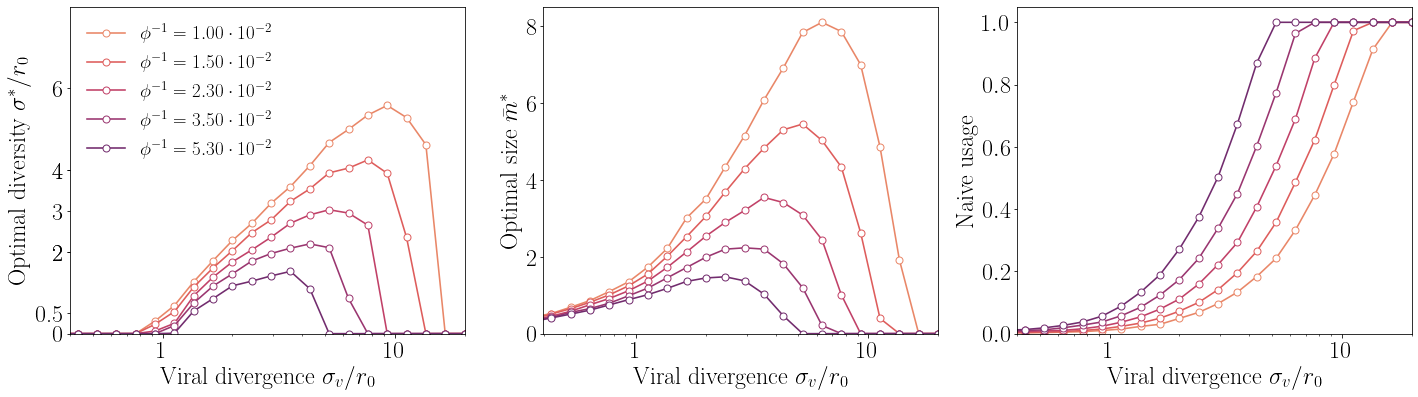

In [5]:
fig_a = plt.figure(figsize  = (12, 10))
gs = fig_a.add_gridspec(ncols = 3, nrows = 2, wspace = 0.05)


(sigvar, numar, sigar, avar, mcpc, params, dim, gamma) = load_data_slices()
nparams = len(params)


invphi_clip = params[1]

sigv_pc = sigvar[16]
sig_pc = sigar[16,1]
num_pc = numar[16,1]

sigv_mc = sigvar[7]
sig_mc = sigar[7,1]
num_mc = numar[7,1]


xp_pc, xv_pc = simulate(sigv_pc, 13, num_pc, 
                        sig_pc, gamma, 1/invphi_clip, 0.4, kick = 0.3,
                        snapshots = [1, 3, 7])

xp_mc, xv_mc = simulate(sigv_mc, 8, num_mc, 
                        sig_mc, gamma, 1/invphi_clip, 0.4, kick = 0.3,
                        snapshots = [1, 3, 7])

axs_pc = [fig_a.add_subplot(gs[1, i]) for i in range(3)]
axs_mc = [fig_a.add_subplot(gs[0, i]) for i in range(3)]


color_map = sns.color_palette("Purples_r", as_cmap = True)

cf_pc, norm = clips(xp_pc, xv_pc, [1, 3, 7], 1/invphi_clip, cmap = color_map, axs = axs_pc, offset = 7)

divider = make_axes_locatable(axs_pc[0])
cax = divider.append_axes("right", "5%", pad="3%")
cax.axis('off')
divider = make_axes_locatable(axs_pc[1])
cax = divider.append_axes("right", "5%", pad="3%")
cax.axis('off')

divider = make_axes_locatable(axs_pc[2])
cax = divider.append_axes("right", "5%", pad="3%")

cbar = plt.colorbar(plt.cm.ScalarMappable(norm = norm, cmap = color_map), 
                      cax = cax)
cbar.set_label(r'$\log I_t$')

cf_mc, norm = clips(xp_mc, xv_mc, [1, 3, 7], 1/invphi_clip, cmap = color_map, axs = axs_mc, offset = 4)

divider = make_axes_locatable(axs_mc[0])
cax = divider.append_axes("right", "5%", pad="3%")
cax.axis('off')

divider = make_axes_locatable(axs_mc[1])
cax = divider.append_axes("right", "5%", pad="3%")
cax.axis('off')

divider = make_axes_locatable(axs_mc[2])
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(plt.cm.ScalarMappable(norm = norm, cmap = color_map),
                      cax = cax)
cbar.set_label(r'$\log I_t$')



save_fig(fig_a, 'fig1_a')

(mcpc, phi_mcpc, pcn, phi_pcn, 
 nu, kappa, gamma) = load_data_pdiag()

fig_b, ax1 = plt.subplots(figsize = (9, 7))

ax1.plot(pcn, phi_pcn, 'C3-', linewidth = 2)
ax1.plot(mcpc, phi_mcpc, 'C0-', linewidth = 2)

ax1.fill_between(pcn, phi_pcn, 0, color = 'C3', alpha = 0.4)
ax1.fill_between(mcpc, phi_mcpc, 0, color = 'w')
ax1.fill_between(mcpc, phi_mcpc, 0, color = 'C0', alpha = 0.4)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(ymin = 0.01)


ax1.set_ylabel(r'Naive density $1/\phi$')
ax1.set_xlabel(r'Viral divergence $\sigma_v/r_0$')

ax1.text(0.5, 0.04, 'Monoclonal\nresponse', 
             rotation = 90)
ax1.text(1.8, 0.02, 'Polyclonal\nresponse')
ax1.text(5, 0.2, 'Naive\n response')
ax1.get_xaxis().set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

ax1.plot(sigv_mc, invphi_clip, 'kx', markersize = 8)
ax1.plot(sigv_pc, invphi_clip, 'kx', markersize = 8)

import matplotlib.ticker

fig_c, (ax3, ax2, ax4) = plt.subplots(ncols = 3, nrows = 1, 
                                    figsize = (3*8, 6), sharex = True)

set_size(5.48, 4.54, ax2)

colors = itertools.cycle(sns.color_palette("flare", n_colors = nparams - 1))
ax2.get_shared_x_axes().join(ax2, ax1)

for k in range(nparams-1):
    color = next(colors)
    ax2.plot(sigvar, numar[:,k], 'o-', markersize = 7, markerfacecolor = 'w', 
             markeredgecolor = color, color = color, linewidth = 1.6)



ax2.set_ylabel(r'Optimal size $\bar m^{*}$')
ax2.set_xlabel(r'Viral divergence $\sigma_{v}/r_0$')
ax2.set_xscale('log')
ax2.get_xaxis().set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax2.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax2.set_ylim(ymin = 0)

sigar[numar < 0.2] = 0


for k in range(nparams-1):
    sigar[sigvar < mcpc[k], k] = 0
    color = next(colors)
    ax3.plot(sigvar, sigar[:,k], 'o-', markersize = 7, markerfacecolor = 'w', linewidth = 1.6,
             markeredgecolor = color, color = color,
             label = r'$\phi^{-1} = %s$' % (format_power(params[k])))
    

ax1.set_xlim(xmin = max(np.min(sigvar),
                        np.min(pcn)), 
             xmax = np.max(sigvar))

x = np.linspace(0, np.max(sigvar), 10)

ax3.legend(frameon = False, loc = 'upper left', fontsize = 19)
ax3.set_ylabel(r'Optimal diversity $\sigma^{*}/r_0$')
ax3.set_xlabel(r'Viral divergence $\sigma_{v}/r_0$')
ax3.set_xscale('log')
#ax3.set_yscale('log')
ax3.get_xaxis().set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax3.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

fig_c.canvas.draw()

yticks = list(ax3.get_yticks())
yticks_labels = [w.get_text() for w in ax3.get_yticklabels()]

yticks_labels += [r'0.5', r'2', r'3', r'4']
yticks += [0.5, 2, 3, 4]

ax3.set_yticks(yticks)
ax3.set_yticklabels(yticks_labels)
ax3.set_ylim([0.0, 8])

for k in range(nparams-1):
    color = next(colors)
    ax4.plot(sigvar, avar[:,k], 'o-', markersize = 7, markerfacecolor = 'w', linewidth = 1.6,
             markeredgecolor = color, color = color)

ax4.set_ylabel(r'Naive usage')
ax4.set_xlabel(r'Viral divergence $\sigma_{v}/r_0$')
ax4.set_xscale('log')
ax4.get_xaxis().set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax4.set_ylim(ymin = 0)
plt.show()

save_fig(fig_c, 'fig1_c')
save_fig(fig_b, 'fig1_b')